# Clip Geotiffs and Evaluate DEM

In [45]:
# see https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html
# and https://rasterio.readthedocs.io/en/latest/quickstart.html

In [21]:
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
from matplotlib import pyplot as plt

In [2]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [44]:
srtm_path = 'srtm_63_06.tif'
img_path = '/Volumes/JROD2/SAR_test/UNWRAP_subset_0_of_S1A_IW_SLC__1SSV_20160408T091355_20160408T091430_010728_01001F_83EB_Orb_Stack_ifg_deb_ML_flt_dem_TC.tif'

In [4]:
srtm = rasterio.open(srtm_path)
img = rasterio.open(img_path)
# shp = rasterio.open(shape_path)

In [33]:
img.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 3567,
 'height': 3271,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.00025107912191140624, 0.0, 130.43624093827813,
        0.0, -0.00025107912191140624, 33.21923208656382)}

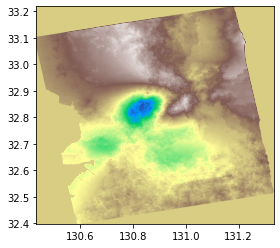

<AxesSubplot:>

In [19]:
show((img, 1), cmap='terrain')

In [37]:
img.bounds

BoundingBox(left=130.43624093827813, bottom=32.397952278791614, right=131.33184016613612, top=33.21923208656382)

In [39]:
# WGS84 coordinates
# minx, miny = 24.60, 60.00
# maxx, maxy = 25.22, 60.35
bbox = box(img.bounds[0], img.bounds[1], img.bounds[2], img.bounds[3])

In [42]:
#Insert the bbox into a GeoDataFrame
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
#Re-project into the same coordinate system as the raster data
geo = geo.to_crs(crs=srtm.crs.data)

In [45]:
coords = getFeatures(geo)
print(coords)

[{'type': 'Polygon', 'coordinates': [[[131.33184016613612, 32.397952278791614], [131.33184016613612, 33.21923208656382], [130.43624093827813, 33.21923208656382], [130.43624093827813, 32.397952278791614], [131.33184016613612, 32.397952278791614]]]}]


In [48]:
# Now we are ready to clip the raster with the polygon using the coords variable that we just created. 
# Clipping the raster can be done easily with the mask function that we imported in the beginning 
# from rasterio, and specifying clip=True.

out_img, out_transform = mask(dataset=srtm, shapes=coords, crop=True)

In [50]:
# Copy the metadata
out_meta = srtm.meta.copy()
print(out_meta)

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 6000, 'height': 6000, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0008333333333333334, 0.0, 130.0,
       0.0, -0.0008333333333333334, 35.0)}


In [51]:
# Parse EPSG code
epsg_code = int(srtm.crs.data['init'][5:])
print(epsg_code)

4326


In [53]:
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
                 )

In [54]:
# save
with rasterio.open("test.tif", "w", **out_meta) as dest:
        dest.write(out_img)

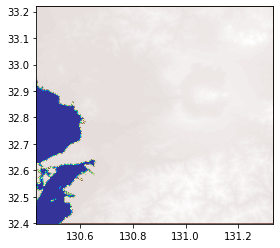

<AxesSubplot:>

In [5]:
clipped = rasterio.open("test.tif")
show((clipped, 1), cmap='terrain')

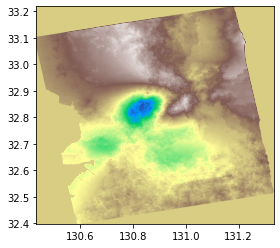

<AxesSubplot:>

In [6]:
show((img, 1), cmap='terrain')

In [29]:
clip_band = clipped.read(1)
img_band = img.read(1)

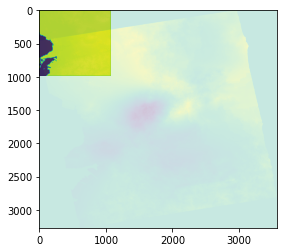

In [65]:
plt.imshow(clip_band)
plt.imshow(img_band, alpha=0.25)


In [67]:
clip_band.shape, img_band.shape

((987, 1076), (3271, 3567))

# Resample

In [8]:
from rasterio.enums import Resampling

In [25]:
upscale_factor = 987 / 3271

# resample data to target shape
data = img.read(
    out_shape=(
        img.count,
        int(img.height * upscale_factor),
        int(img.width * upscale_factor)
    ),
    resampling=Resampling.bilinear
)

# scale image transform
# transform = img.transform * img.transform.scale(
#     (img.width / data.shape[-1]),
#     (img.height / data.shape[-2])
# )

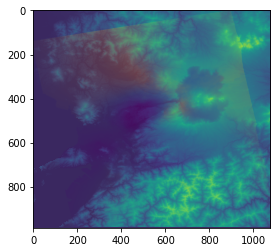

In [37]:
plt.imshow(clip_band,vmin=0, vmax=2000)
plt.imshow(data[0], alpha = 0.25)

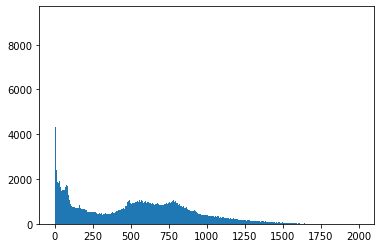

In [43]:
plt.hist(clip_band.flatten(), range(0,2000))
plt.show()

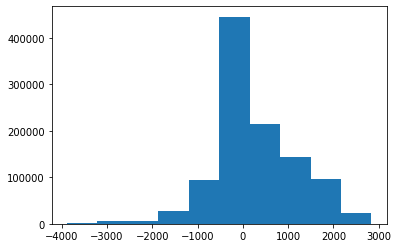

In [39]:
plt.hist(data[0].flatten())
plt.show()